<a href="https://colab.research.google.com/github/shalini61298/Twitter_Analysis/blob/main/phaseFULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import transformers
import torch
import pandas as pd
from torch.utils import data
from sklearn.model_selection import train_test_split
from transformers import ( AdamW, BertModel, RobertaModel)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import nltk
import numpy as np
from torch import nn
from collections import defaultdict
import string
import re
import csv
import argparse
import gc
import sys
import os
from nltk import word_tokenize


In [ ]:
# Stemming
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
ps = nltk.PorterStemmer()

# Stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

def string_to_bool(string):

    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):

    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):

    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y


config     = {"model_class": "RoBERTa",
"model" : "roberta-base",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("32"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None



try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)
  #assert train_data.shape == (69, 3) , "train.tsv should contain 7000 rows, only found " + str(train_data.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

try:
  df_val = pd.read_csv('fakenewsoutput.tsv', sep=r'\t', header=0)

  #assert df_val.shape == (9, 3) , "valid.tsv should contain 1000 rows, only found " + str(df_val.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit



# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
  df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

# Currently the labels in our dataframes are "UNINFORMATIVE" or "INFORMATIVE"
train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)


# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer),
    "RoBERTa": (RobertaModel, RobertaTokenizer)
}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:

  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)


class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }


def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
  test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

def clean_text(text):

    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)

# Model Classes

class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)


  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0, :]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class BertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)


  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None,
              ensemble=None, tfidf_feats=None, avg_feats=None):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    model_output = outputs[0]
    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)
    outputs = (logits,)
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs
    return outputs

# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]

# Two different classification heads - distinct by a dropout layer
classification_head = (BertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)
model = model.to(device)
LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]
WEIGHT_DECAY     = 0
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS
if config["model_class"] == "RoBERTa":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.

schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Training Loop

history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    'train' : train_dataloader,
    'val'   : val_dataloader
}


for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in ['train', 'val']:

    if phase == 'train':
      print('Running training step...\n')


    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode


    for batch in dataloader[phase]:

      #Unpack batch
      input_ids      = batch.get('input_ids').to(device)
      attention_mask = batch.get('attention_mask').to(device)
      labels         = batch.get('label').to(device)
      # Declare a none-type variable where model not ensemble - only concatenated where ensemble == True
      tfidf_feats = None

      if ENSEMBLE:
        tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


        tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)


      avg_feats      = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)


      model.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):

        loss, logits = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              ensemble=ENSEMBLE,
                              tfidf_feats=tfidf_feats,
                              avg_feats=avg_feats) # Default is None, but need to declare a var for when ensemble True


        total_loss += loss.item()


        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()


        total_acc += flat_accuracy(logits, label_ids)

        if phase == 'train':


          loss.backward()


          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


          optimizer.step()


          schedular.step()

    avg_acc  = total_acc / len(dataloader[phase])
    avg_loss = total_loss / len(dataloader[phase])

    if phase == 'train':
      print("Training step complete. \n")

    print("   Average loss: {0:.2f}".format(avg_loss))
    print("   Average accuracy {0:.2f}".format(avg_acc))
    print("")


    history[phase +'_loss'].append(avg_loss)
    history[phase +'_acc'].append(avg_acc)


print("\nTraining complete!")

print('\nPredicting the values.')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)


  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[1]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')


# Write to CSV
from sklearn.metrics import classification_report



y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())

flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]

df = pd.DataFrame(flat_predictions,columns =['labels'])
print(df)
#print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def compute_metrics(labels, predictions):

    precision = precision_score(labels, predictions, pos_label=1, average='binary')
    recall    = recall_score(labels, predictions, pos_label=1, average='binary')
    # weighted f1-score
    f1        = f1_score(labels, predictions, average='weighted')
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0,1]).ravel()

    return {
        "precision" : precision,
        "recall"    : recall,
        "f1_score"  : f1,
        "tp"        : tp,
        "fp"        : fp,
        "fn"        : fn,
        "tn"        : tn
    }



try:
  with open('./transformer_model_tests.csv', 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    metrics = compute_metrics(flat_true_labels, flat_predictions)

    csv_writer.writerow([config['model_class'], config['model'], config['split_train'],
                         config['preprocessed'], config['ensemble'],config['save_model'],
                         config['random_seed'],config['max_len'], config['batch_size'],
                         config['learning_rate'], config['epochs'], config['dropout_prob'],config['max_feats'],
                         history['train_acc'], history['val_acc'], history['train_loss'],history['val_loss'],
                         metrics['precision'], metrics['recall'], metrics['f1_score'],
                         metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn']])

except IOError as e:
  sys.stderr.write('Error opening file trandormer_model_tests.csv' + e.strerror + '\n')
  raise SystemExit

# Save Model
if config['save_model']:

  output_dir = './'+config['model']+'_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  torch.save(model.state_dict(), output_dir + '_model_state.pt')
  torch.save(model, output_dir + 'model.pt')

# ==============================================================================================================================================
# Memory optimization
del model, optimizer, schedular

gc.collect()

torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


======== Epoch 1 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.70
   Average accuracy 0.54



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.68
   Average accuracy 0.87

======== Epoch 2 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.61
   Average accuracy 0.67



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.58
   Average accuracy 0.73

======== Epoch 3 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.34
   Average accuracy 0.88



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.83
   Average accuracy 0.74

======== Epoch 4 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.14
   Average accuracy 0.97



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.78
   Average accuracy 0.78


Training complete!

Predicting the values.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   DONE!
     labels
0         0
1         1
2         1
3         0
4         1
..      ...
995       1
996       0
997       0
998       0
999       0

[1000 rows x 1 columns]


In [ ]:
df1 = pd.read_csv("fakenewsoutput1.tsv",sep="\t")
sep=df1['Text']
sep=sep.to_frame()
type(sep)
result = pd.concat([sep,df], axis=1)
result.head()
result.to_csv("Roberta.csv")

In [ ]:
# ==============================================================================================================================================
# Functions

def string_to_bool(string):

    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):

    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):

    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y

# ==============================================================================================================================================
# Set up arguments



config     = {"model_class": "BERT",
"model" : "bert-base-uncased",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("32"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None

# ==============================================================================================================================================
# read in data

try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)
  #assert train_data.shape == (69, 3) , "train.tsv should contain 7000 rows, only found " + str(train_data.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

try:
  df_val = pd.read_csv('fakenewsoutput.tsv', sep=r'\t', header=0)
  #assert df_val.shape == (9, 3) , "valid.tsv should contain 1000 rows, only found " + str(df_val.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit



# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
  df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)


# ==============================================================================================================================================
# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer),
    "RoBERTa": (RobertaModel, RobertaTokenizer)
}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:
  # Propogate random_state
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

#transformer_model.config.model_type

# ==============================================================================================================================================

class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
  test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create loaders for training, test and val data
train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# ==============================================================================================================================================
# TF-IDF MODEL

# Define a method that will passed as an analyzer to the TfidfVectorizer
def clean_text(text):

    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)

# ==============================================================================================================================================
# Model Classes

class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)


  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0, :]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class BertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)

  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None, ensemble=None, tfidf_feats=None, avg_feats=None):

    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)



    model_output = outputs[0]

    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)

    outputs = (logits,)


    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs

    return outputs

# ==============================================================================================================================================
# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]

# Two different classification heads - distinct by a dropout layer
classification_head = (BertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)

# Move to the GPU
model = model.to(device)

LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]

WEIGHT_DECAY     = 0 # defaults to 0 in AdamW
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS

if config["model_class"] == "RoBERTa":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS) # 0.06 ratio


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.

schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# ==============================================================================================================================================
# Training Loop

history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    'train' : train_dataloader,
    'val'   : val_dataloader
}

for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in ['train', 'val']:

    if phase == 'train':
      print('Running training step...\n')
    else:
      print('Running validation...\n')

    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode


    for batch in dataloader[phase]:

      #Unpack batch
      input_ids      = batch.get('input_ids').to(device)
      attention_mask = batch.get('attention_mask').to(device)
      labels         = batch.get('label').to(device)
      # Declare a none-type variable where model not ensemble - only concatenated where ensemble == True
      tfidf_feats = None

      if ENSEMBLE:
        tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


        tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

      # apply average nums to each text item, and reshape to tensor of [32,1]
      avg_feats      = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

      # Pytorch accumulates the gradients on backward pass so need to set them to zero.
      model.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):

        loss, logits = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              ensemble=ENSEMBLE,
                              tfidf_feats=tfidf_feats,
                              avg_feats=avg_feats) # Default is None, but need to declare a var for when ensemble True

        total_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        total_acc += flat_accuracy(logits, label_ids)

        if phase == 'train':

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Use gradient clipping to prevent exploding gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters
          optimizer.step()

          # Update the learning rate.
          schedular.step()

    avg_acc  = total_acc / len(dataloader[phase])
    avg_loss = total_loss / len(dataloader[phase])

    if phase == 'train':
      print("Training step complete. \n")
   # else:
     # print('Validation step complete. \n')

    print("   Average loss: {0:.2f}".format(avg_loss))
    print("   Average accuracy {0:.2f}".format(avg_acc))
    print("")

    # Record all statistics from this epoch and phase.
    history[phase +'_loss'].append(avg_loss)
    history[phase +'_acc'].append(avg_acc)


print("\nTraining complete!")

print('\nPrediction values')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)


  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[1]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')


# ==============================================================================================================================================
# Write to CSV
from sklearn.metrics import classification_report



y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())

flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]
#print(flat_predictions)
df11 = pd.DataFrame(flat_predictions,columns =['labels'])
print(df11)
#print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def compute_metrics(labels, predictions):

    # precision and recall only for INFORMATIVE class
    precision = precision_score(labels, predictions, pos_label=1, average='binary')
    recall    = recall_score(labels, predictions, pos_label=1, average='binary')
    # weighted f1-score
    f1        = f1_score(labels, predictions, average='weighted')
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0,1]).ravel()

    return {
        "precision" : precision,
        "recall"    : recall,
        "f1_score"  : f1,
        "tp"        : tp,
        "fp"        : fp,
        "fn"        : fn,
        "tn"        : tn
    }

#Write out to csv file:

try:
  with open('./transformer_model_tests.csv', 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    metrics = compute_metrics(flat_true_labels, flat_predictions)

    csv_writer.writerow([config['model_class'], config['model'], config['split_train'],
                         config['preprocessed'], config['ensemble'],config['save_model'],
                         config['random_seed'],config['max_len'], config['batch_size'],
                         config['learning_rate'], config['epochs'], config['dropout_prob'],config['max_feats'],
                         history['train_acc'], history['val_acc'], history['train_loss'],history['val_loss'],
                         metrics['precision'], metrics['recall'], metrics['f1_score'],
                         metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn']])

except IOError as e:
  sys.stderr.write('Error opening file trandormer_model_tests.csv' + e.strerror + '\n')
  raise SystemExit

# ==============================================================================================================================================
# Save Model
if config['save_model']:

  output_dir = './'+config['model']+'_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)


  torch.save(model.state_dict(), output_dir + '_model_state.pt')
  torch.save(model, output_dir + 'model.pt')

# ==============================================================================================================================================
# Memory optimization
del model, optimizer, schedular

gc.collect()

torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


======== Epoch 1 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.69
   Average accuracy 0.56

Running validation...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.53
   Average accuracy 0.81

======== Epoch 2 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.31
   Average accuracy 0.88

Running validation...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.48
   Average accuracy 0.82

======== Epoch 3 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.10
   Average accuracy 0.97

Running validation...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.63
   Average accuracy 0.82

======== Epoch 4 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.04
   Average accuracy 0.99

Running validation...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   Average loss: 0.54
   Average accuracy 0.84


Training complete!

Prediction values


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   DONE!
     labels
0         0
1         1
2         1
3         0
4         1
..      ...
995       1
996       0
997       0
998       0
999       0

[1000 rows x 1 columns]


In [ ]:
df1 = pd.read_csv("fakenewsoutput1.tsv",sep="\t")
sep=df1['Text']
sep=sep.to_frame()
type(sep)
result = pd.concat([sep,df11], axis=1)
result
result.to_csv('bert.csv')


In [ ]:
# ==============================================================================================================================================
# Functions

def string_to_bool(string):

    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):

    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):

    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y

# ==============================================================================================================================================
# Set up arguments



config     = {"model_class": "CTBERT",
"model" : "digitalepidemiologylab/covid-twitter-bert",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("16"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None

# ==============================================================================================================================================
# read in data

try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)

except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

try:
  df_val = pd.read_csv('fakenewsoutput.tsv', sep=r'\t', header=0)

except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit



# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
  df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)


# ==============================================================================================================================================
# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer)


}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:
  # Propogate random_state
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

#transformer_model.config.model_type

# ==============================================================================================================================================
# Datasets and Dataloader


class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }


def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=2
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
  test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create loaders for training, test and val data
train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# ==============================================================================================================================================
# TF-IDF MODEL

# Define a method that will passed as an analyzer to the TfidfVectorizer
def clean_text(text):

    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)

# ==============================================================================================================================================
# Model Classes

class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)


  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class CtBertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)


  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None, ensemble=None, tfidf_feats=None, avg_feats=None):

    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)



    model_output = outputs[0]

    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)

    outputs = (logits,)

    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs

    return outputs

# ==============================================================================================================================================
# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]


classification_head = (CtBertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)

# Move to the GPU
gc.collect()
torch.cuda.empty_cache()
model = model.to(device)


LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]

WEIGHT_DECAY     = 0 # defaults to 0 in AdamW
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS

if config["model_class"] == "XLNetModel":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS) # 0.06 ratio


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.


schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# ==============================================================================================================================================
# Training Loop

history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    'train' : train_dataloader,
    'val'   : val_dataloader
}

for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in ['train', 'val']:

    if phase == 'train':
      print('Running training step...\n')


    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode


    for batch in dataloader[phase]:

      #Unpack batch
      input_ids      = batch.get('input_ids').to(device)
      attention_mask = batch.get('attention_mask').to(device)
      labels         = batch.get('label').to(device)
      # Declare a none-type variable where model not ensemble - only concatenated where ensemble == True
      tfidf_feats = None

      if ENSEMBLE:
        tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


        tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

      # apply average nums to each text item, and reshape to tensor of [32,1]
      avg_feats      = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

      # Pytorch accumulates the gradients on backward pass so need to set them to zero.
      model.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):

        loss, logits = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              ensemble=ENSEMBLE,
                              tfidf_feats=tfidf_feats,
                              avg_feats=avg_feats) # Default is None, but need to declare a var for when ensemble True


        total_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        total_acc += flat_accuracy(logits, label_ids)

        if phase == 'train':

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Use gradient clipping to prevent exploding gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters
          optimizer.step()

          # Update the learning rate.
          schedular.step()

    avg_acc  = total_acc / len(dataloader[phase])
    avg_loss = total_loss / len(dataloader[phase])

    if phase == 'train':
      print("Training step complete. \n")


    print("   Average loss: {0:.2f}".format(avg_loss))
    print("   Average accuracy {0:.2f}".format(avg_acc))
    print("")

    # Record all statistics from this epoch and phase.
    history[phase +'_loss'].append(avg_loss)
    history[phase +'_acc'].append(avg_acc)


print("\nTraining complete!")

print('\nPerforming Evaluation on Test Set.')

model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch


    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[1]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')


# ==============================================================================================================================================
# Write to CSV
from sklearn.metrics import classification_report


y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())


flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]
df22 = pd.DataFrame(flat_predictions,columns =['labels'])
print(df22)
#print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def compute_metrics(labels, predictions):

    # precision and recall only for INFORMATIVE class
    precision = precision_score(labels, predictions, pos_label=1, average='binary')
    recall    = recall_score(labels, predictions, pos_label=1, average='binary')
    # weighted f1-score
    f1        = f1_score(labels, predictions, average='weighted')
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0,1]).ravel()

    return {
        "precision" : precision,
        "recall"    : recall,
        "f1_score"  : f1,
        "tp"        : tp,
        "fp"        : fp,
        "fn"        : fn,
        "tn"        : tn
    }

#Write out to csv file:

try:
  with open('./transformer_model_tests.csv', 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    metrics = compute_metrics(flat_true_labels, flat_predictions)

    csv_writer.writerow([config['model_class'], config['model'], config['split_train'],
                         config['preprocessed'], config['ensemble'],config['save_model'],
                         config['random_seed'],config['max_len'], config['batch_size'],
                         config['learning_rate'], config['epochs'], config['dropout_prob'],config['max_feats'],
                         history['train_acc'], history['val_acc'], history['train_loss'],history['val_loss'],
                         metrics['precision'], metrics['recall'], metrics['f1_score'],
                         metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn']])

except IOError as e:
  sys.stderr.write('Error opening file trandormer_model_tests.csv' + e.strerror + '\n')
  raise SystemExit

# ==============================================================================================================================================
# Save Model
if config['save_model']:

  output_dir = './'+config['model']+'_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  torch.save(model.state_dict(), output_dir + '_model_state.pt')
  torch.save(model, output_dir + 'model.pt')

# ==============================================================================================================================================
# Memory optimization
del model, optimizer, schedular

gc.collect()

torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


======== Epoch 1 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.45
   Average accuracy 0.79



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

   Average loss: 0.80
   Average accuracy 0.83

======== Epoch 2 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.13
   Average accuracy 0.97



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

   Average loss: 0.99
   Average accuracy 0.82

======== Epoch 3 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.04
   Average accuracy 0.99



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

   Average loss: 1.22
   Average accuracy 0.80

======== Epoch 4 / 4 ========
Running training step...



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training step complete. 

   Average loss: 0.00
   Average accuracy 1.00



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

   Average loss: 1.14
   Average accuracy 0.82


Training complete!

Performing Evaluation on Test Set.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

   DONE!
     labels
0         0
1         1
2         1
3         0
4         0
..      ...
995       0
996       0
997       0
998       0
999       0

[1000 rows x 1 columns]


In [ ]:
df1 = pd.read_csv("fakenewsoutput1.tsv",sep="\t")
sep=df1['Text']
sep=sep.to_frame()
type(sep)
result = pd.concat([sep,df22], axis=1)
result.to_csv('ctbert.csv')

In [ ]:
all=pd.concat([df,df11,df22], axis=1)
all
value=[]
for i in range(0,len(all.index)):
  s=all.iloc[i].tolist()
  #print(s)
  value.append(max(s,key=s.count))
print(value)

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
final = pd.DataFrame(value,columns =['labels'])
final
result = pd.concat([sep,final], axis=1)
result.to_csv('finaloutbert.csv')

In [ ]:
result  = result.loc[(result["labels"] ==1 )]
display(result)


,Text,labels
1,Death happens all the time but is something we...,1
2,Hoda Kotb Shares a Touching Tribute to a Belov...,1
4,The number of confirmed coronavirus cases in N...,1
6,@USER @USER Where is proof that thousand of pe...,1
9,There are eight new cases of #COVID19 in #Sask...,1
...,...,...
976,coronavirusupd indiafightscorona india recover...,1
989,daili updat publish state report test case dea...,1
991,third case arriv juli india stay isol stamford...,1
993,total number confirm case covid number report ...,1


In [ ]:
result.replace(1,
           "INFORMATIVE",
           inplace=True)

result

,Text,labels
1,Death happens all the time but is something we...,INFORMATIVE
2,Hoda Kotb Shares a Touching Tribute to a Belov...,INFORMATIVE
4,The number of confirmed coronavirus cases in N...,INFORMATIVE
6,@USER @USER Where is proof that thousand of pe...,INFORMATIVE
9,There are eight new cases of #COVID19 in #Sask...,INFORMATIVE
...,...,...
976,coronavirusupd indiafightscorona india recover...,INFORMATIVE
989,daili updat publish state report test case dea...,INFORMATIVE
991,third case arriv juli india stay isol stamford...,INFORMATIVE
993,total number confirm case covid number report ...,INFORMATIVE


In [ ]:
result.to_csv('Bertmodelout.csv')

## EXTRA

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 13.9 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 61.0 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# ==============================================================================================================================================
# Functions

def string_to_bool(string):
    """
    Converts a string representation of a boolean to a boolean
    :param string: A string "True" or "False"
    :return: boolean value
    """
    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):
    """
    Method for pre_processing tweet text:
     * converting "HTTPURL" to "http" and splitting camelcased hashtags.
     * parsing for "covid-19" and "coronavirus" and standardizing to "coronavirus"
    Regex term for splitting derived from https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
    with additional implementation for computation in list comprehension.
    """
    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):
    """
    Function to remove unicode emojis.
    :param data: The text data from which to remove emojis.
    :return: The data with emojis removed.
    """
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):
    """
    Function to return the percentage probability of any character in the text
    being numeric. Parsing and removing emojis to prevent the influence of numbers
    in unicode characters.
    :param text: The tweet text.
    :return: A (1,1) tensor of the probability of any character being numeric.
    """
    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y

# ==============================================================================================================================================
# Set up arguments
'''parser = argparse.ArgumentParser(description='Script that utalises task spooler to run multiple hyperparameter experiments')

parser.add_argument('model_class', type=str, help='model class: BERT or RoBERTa')

parser.add_argument('model', type=str, help='model: e.g.bert-base-uncased')

parser.add_argument('random_seed', type=str)
parser.add_argument('max_len', type=str)
parser.add_argument('epochs', type=str)

parser.add_argument('learning_rate', type=str)
parser.add_argument('batch_size', type=str)
parser.add_argument('dropout_prob', type=str)
parser.add_argument('test_size', type=str)
parser.add_argument('preprocessed', type=str)

parser.add_argument('ensemble', type=str)
parser.add_argument('num_labels', type=str)
parser.add_argument('max_feats', type=str)
parser.add_argument('save_model', type=str)
parser.add_argument('split_train', type=str)

args = parser.parse_args()

'''


config     = {"model_class": "RoBERTa",
"model" : "roberta-base",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("32"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None

# ==============================================================================================================================================
# read in data

try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)
  assert train_data.shape == (69, 3) , "train.tsv should contain 7000 rows, only found " + str(train_data.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

'''try:
  df_val = pd.read_csv('valid.tsv', sep=r'\t', header=0)
  assert df_val.shape == (9, 3) , "valid.tsv should contain 1000 rows, only found " + str(df_val.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit'''



# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
 # df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

# Currently the labels in our dataframes are "UNINFORMATIVE" or "INFORMATIVE"
# It is therefore neccessary to convert these to binary values for classification
train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
#df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)


# ==============================================================================================================================================
# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer),
    "RoBERTa": (RobertaModel, RobertaTokenizer)
}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:
  # Propogate random_state
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

#transformer_model.config.model_type

# ==============================================================================================================================================
# Datasets and Dataloader

# Note -- this is the same implementation used in BERT_baseline

# Pytorch dataset classes are extensions of the base abstract dataset class
# it is neccessary to override the __len__ method (returning the size of the dataset), and
# __getitem__ (which defined how to get the next item in the dataset).
#
# For more info see (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
#
# This dataset returns a dictionary of the text, input_ids, attention_mask and label for a tweet.
# It is important to return pytorch tensors, which is the format that the BERT model expects.
#
# Class derived from (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }

# Note -- this is the same implementation used in BERT_baseline

# Wrap these datasets into pytorch dataloaders
# Credit for this method goes to (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
 # test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create loaders for training, test and val data
train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
#val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# ==============================================================================================================================================
# TF-IDF MODEL

# Define a method that will passed as an analyzer to the TfidfVectorizer
def clean_text(text):
    """
    Method to clean the tweet text, removing case, removing stopwords and punctuation and tokenizing.
    This will be parsed to the TfidfVectoriser as an analyzer and applied to each tweet in fitting.
    :param text: The text of each tweet
    :return: The text tokenized, with punctuation and stopwords removed.
    """
    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)

# ==============================================================================================================================================
# Model Classes

class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)

  # Derived from (https://huggingface.co/transformers/v1.1.0/_modules/pytorch_transformers/modeling_roberta.html)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0, :]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class BertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)

  # Dervied from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertModel)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None, ensemble=None, tfidf_feats=None, avg_feats=None):

    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    # if self.model.config.model_type == 'bert':
    #   # 'outputs' is a tuple (sequence_output, pooled_output).
    #   # The pooled_output is the last hidden-state of the [CLS] token further process by a Linear layer and tanh function
    #   model_output = outputs[1]

    # else:
    #   # 'outputs' is raw hidden states from RoBERTa
    #   # Therefore take the sequence output of dimensions (batch_size, max_len, hidden_size)
    #   model_output = outputs[0]

    # Need to avoid using pooled output from BERT (where making use of tfidf)
    # therefore in each case BERT and RoBERTa going to use the sequence output
    # and in the classification head extract the CLS token or equivalent

    model_output = outputs[0]

    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)

    outputs = (logits,)

    # Following derived from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification)
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs

    return outputs

# ==============================================================================================================================================
# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]

# Two different classification heads - distinct by a dropout layer
classification_head = (BertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)

# Move to the GPU
model = model.to(device)

LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]

WEIGHT_DECAY     = 0 # defaults to 0 in AdamW
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS

if config["model_class"] == "RoBERTa":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS) # 0.06 ratio

# Use a pytorch optimizer to preform updates on parameters.
# This is the Adam algorithm with weight decay fix. This is the same optimizer
# implemented in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# and the hugginface implementation of transformer models on the GLUE dataset,
# see (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.

# Create a schedular which will update the learning rate.
# This uses the defualt num_warmup_steps from:
# (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L392)
schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

# Function to calculate the accuracy of a batch of predictions vs true labels
# Function is derived from (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# ==============================================================================================================================================
# Training Loop

# The below code forms the fine-tuning training loop of our model on the new data.
# This code was influenced by (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk).
# With ammendments to reflect the change that our dataset returns a dictionary, and the introduction of a phase for loop to reduce visual complexity.

# As in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# we will store the losses associated with training and validiation.
history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    'train' : train_dataloader,
 #   'val'   : val_dataloader
}

# Phase concept derived from (https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)
for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in ['train']:

    if phase == 'train':
      print('Running training step...\n')
    else:
      print('Running validation...\n')

    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval
        ()   # Set model to evaluate mode


    for batch in dataloader[phase]:

      #Unpack batch
      input_ids      = batch.get('input_ids').to(device)
      attention_mask = batch.get('attention_mask').to(device)
      labels         = batch.get('label').to(device)
      # Declare a none-type variable where model not ensemble - only concatenated where ensemble == True
      tfidf_feats = None

      if ENSEMBLE:
        tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch

        #transform to tensor - derived from https://github.com/donglinchen/text_classification/blob/master/model_pytorch.ipynb
        tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

      # apply average nums to each text item, and reshape to tensor of [32,1]
      avg_feats      = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

      # Pytorch accumulates the gradients on backward pass so need to set them to zero.
      model.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        # Perform a forward pass on this training batch.
        # As explained in (https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification),
        # because we pass the true labels, the classification loss is returned along with the classification
        # scores before normalizaition ("logits")
        loss, logits = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              ensemble=ENSEMBLE,
                              tfidf_feats=tfidf_feats,
                              avg_feats=avg_feats) # Default is None, but need to declare a var for when ensemble True

        # Accumulate the training loss to calculate average loss for this epoch.
        # loss.item() extracts the value from the loss tensor as a python float.
        total_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        total_acc += flat_accuracy(logits, label_ids)

        if phase == 'train':

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Use gradient clipping to prevent exploding gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters
          optimizer.step()

          # Update the learning rate.
          schedular.step()

    avg_acc  = total_acc / len(dataloader[phase])
    avg_loss = total_loss / len(dataloader[phase])

    if phase == 'train':
      print("Training step complete. \n")
    else:
      print('Validation step complete. \n')

    print("   Average loss: {0:.2f}".format(avg_loss))
    print("   Average accuracy {0:.2f}".format(avg_acc))
    print("")

    # Record all statistics from this epoch and phase.
    history[phase +'_loss'].append(avg_loss)
    history[phase +'_acc'].append(avg_acc)


print("\nTraining complete!")

print('\nPerforming Evaluation on Test Set.')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch

    #transform to tensor - derived from https://github.com/donglinchen/text_classification/blob/master/model_pytorch.ipynb
    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

  # apply average nums to each text item, and reshape to tensor of [32,1]
  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[1]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')


# ==============================================================================================================================================
# Write to CSV
from sklearn.metrics import classification_report

# The predictions for each batch are a 2-column ndarray (one column for "0"
# and one column for "1"). With rows refelcting the weight
# of the predicition for each label. Identify the highest value and covert
# in to a list of 0s and 1s.

y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())

# Y_preds stores an array for each batch in our predicitions
# to produce a classification report, extract each item in these sublists to a
# flattend array.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]

df = pd.DataFrame(flat_predictions,columns =['labels'])
print(df)
print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def compute_metrics(labels, predictions):

    # precision and recall only for INFORMATIVE class
    precision = precision_score(labels, predictions, pos_label=1, average='binary')
    recall    = recall_score(labels, predictions, pos_label=1, average='binary')
    # weighted f1-score
    f1        = f1_score(labels, predictions, average='weighted')
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0,1]).ravel()

    return {
        "precision" : precision,
        "recall"    : recall,
        "f1_score"  : f1,
        "tp"        : tp,
        "fp"        : fp,
        "fn"        : fn,
        "tn"        : tn
    }

#Write out to csv file:

try:
  with open('./transformer_model_tests.csv', 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    metrics = compute_metrics(flat_true_labels, flat_predictions)

    csv_writer.writerow([config['model_class'], config['model'], config['split_train'],
                         config['preprocessed'], config['ensemble'],config['save_model'],
                         config['random_seed'],config['max_len'], config['batch_size'],
                         config['learning_rate'], config['epochs'], config['dropout_prob'],config['max_feats'],
                         history['train_acc'], history['val_acc'], history['train_loss'],history['val_loss'],
                         metrics['precision'], metrics['recall'], metrics['f1_score'],
                         metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn']])

except IOError as e:
  sys.stderr.write('Error opening file trandormer_model_tests.csv' + e.strerror + '\n')
  raise SystemExit

# ==============================================================================================================================================
# Save Model
if config['save_model']:

  output_dir = './'+config['model']+'_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Pytorch reccomends saving models using save/load state dict
  # see (https://pytorch.org/tutorials/beginner/saving_loading_models.html#:~:text=Save%2FLoad%20state_dict%20(Recommended)&text=Saving%20the%20model's%20state_dict%20with,pt%20or%20.)
  torch.save(model.state_dict(), output_dir + '_model_state.pt')
  torch.save(model, output_dir + 'model.pt')

# ==============================================================================================================================================
# Memory optimization
del model, optimizer, schedular

gc.collect()

torch.cuda.empty_cache()


In [ ]:
# ==============================================================================================================================================
# Functions

def string_to_bool(string):
    """
    Converts a string representation of a boolean to a boolean
    :param string: A string "True" or "False"
    :return: boolean value
    """
    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):
    """
    Method for pre_processing tweet text:
     * converting "HTTPURL" to "http" and splitting camelcased hashtags.
     * parsing for "covid-19" and "coronavirus" and standardizing to "coronavirus"
    Regex term for splitting derived from https://stackoverflow.com/questions/29916065/how-to-do-camelcase-split-in-python
    with additional implementation for computation in list comprehension.
    """
    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):
    """
    Function to remove unicode emojis.
    :param data: The text data from which to remove emojis.
    :return: The data with emojis removed.
    """
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):
    """
    Function to return the percentage probability of any character in the text
    being numeric. Parsing and removing emojis to prevent the influence of numbers
    in unicode characters.
    :param text: The tweet text.
    :return: A (1,1) tensor of the probability of any character being numeric.
    """
    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y

# ==============================================================================================================================================
# Set up arguments
'''parser = argparse.ArgumentParser(description='Script that utalises task spooler to run multiple hyperparameter experiments')

parser.add_argument('model_class', type=str, help='model class: BERT or RoBERTa')

parser.add_argument('model', type=str, help='model: e.g.bert-base-uncased')

parser.add_argument('random_seed', type=str)
parser.add_argument('max_len', type=str)
parser.add_argument('epochs', type=str)

parser.add_argument('learning_rate', type=str)
parser.add_argument('batch_size', type=str)
parser.add_argument('dropout_prob', type=str)
parser.add_argument('test_size', type=str)
parser.add_argument('preprocessed', type=str)

parser.add_argument('ensemble', type=str)
parser.add_argument('num_labels', type=str)
parser.add_argument('max_feats', type=str)
parser.add_argument('save_model', type=str)
parser.add_argument('split_train', type=str)

args = parser.parse_args()

'''




"parser = argparse.ArgumentParser(description='Script that utalises task spooler to run multiple hyperparameter experiments')\n\nparser.add_argument('model_class', type=str, help='model class: BERT or RoBERTa')\n\nparser.add_argument('model', type=str, help='model: e.g.bert-base-uncased')\n\nparser.add_argument('random_seed', type=str)\nparser.add_argument('max_len', type=str)\nparser.add_argument('epochs', type=str)\n\nparser.add_argument('learning_rate', type=str)\nparser.add_argument('batch_size', type=str)\nparser.add_argument('dropout_prob', type=str)\nparser.add_argument('test_size', type=str)\nparser.add_argument('preprocessed', type=str)\n\nparser.add_argument('ensemble', type=str)\nparser.add_argument('num_labels', type=str)\nparser.add_argument('max_feats', type=str)\nparser.add_argument('save_model', type=str)\nparser.add_argument('split_train', type=str)\n\nargs = parser.parse_args()\n\n"

In [ ]:
config     = {"model_class": "RoBERTa",
"model" : "roberta-base",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("32"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None

# ==============================================================================================================================================
# read in data

try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)
  assert train_data.shape == (69, 3) , "train.tsv should contain 7000 rows, only found " + str(train_data.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

try:
  df_val = pd.read_csv('valid.tsv', sep=r'\t', header=0)
  #assert df_val.shape == (9, 3) , "valid.tsv should contain 1000 rows, only found " + str(df_val.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [ ]:


# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
  df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

# Currently the labels in our dataframes are "UNINFORMATIVE" or "INFORMATIVE"
# It is therefore neccessary to convert these to binary values for classification
train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
#df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)




In [ ]:
# ==============================================================================================================================================
# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer),
    "RoBERTa": (RobertaModel, RobertaTokenizer)
}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:
  # Propogate random_state
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

#transformer_model.config.model_type



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# ==============================================================================================================================================
# Datasets and Dataloader

# Note -- this is the same implementation used in BERT_baseline

# Pytorch dataset classes are extensions of the base abstract dataset class
# it is neccessary to override the __len__ method (returning the size of the dataset), and
# __getitem__ (which defined how to get the next item in the dataset).
#
# For more info see (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
#
# This dataset returns a dictionary of the text, input_ids, attention_mask and label for a tweet.
# It is important to return pytorch tensors, which is the format that the BERT model expects.
#
# Class derived from (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }

# Note -- this is the same implementation used in BERT_baseline

# Wrap these datasets into pytorch dataloaders
# Credit for this method goes to (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
  test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create loaders for training, test and val data
train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
#val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# ==============================================================================================================================================
# Datasets and Dataloader

# Note -- this is the same implementation used in BERT_baseline

# Pytorch dataset classes are extensions of the base abstract dataset class
# it is neccessary to override the __len__ method (returning the size of the dataset), and
# __getitem__ (which defined how to get the next item in the dataset).
#
# For more info see (https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
#
# This dataset returns a dictionary of the text, input_ids, attention_mask and label for a tweet.
# It is important to return pytorch tensors, which is the format that the BERT model expects.
#
# Class derived from (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
class tweet_dataset(data.Dataset):

  def __init__(self, id, text,  tokenizer, max_len):
    self.id = id
    self.text = text
    #self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
     #   'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }

# Note -- this is the same implementation used in BERT_baseline

# Wrap these datasets into pytorch dataloaders
# Credit for this method goes to (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      #label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# ==============================================================================================================================================
# TF-IDF MODEL

# Define a method that will passed as an analyzer to the TfidfVectorizer
def clean_text(text):
    """
    Method to clean the tweet text, removing case, removing stopwords and punctuation and tokenizing.
    This will be parsed to the TfidfVectoriser as an analyzer and applied to each tweet in fitting.
    :param text: The text of each tweet
    :return: The text tokenized, with punctuation and stopwords removed.
    """
    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)



In [ ]:
# ==============================================================================================================================================
# Model Classes

class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)

  # Derived from (https://huggingface.co/transformers/v1.1.0/_modules/pytorch_transformers/modeling_roberta.html)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0, :]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class BertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)

  # Dervied from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertModel)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None, ensemble=None, tfidf_feats=None, avg_feats=None):

    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    # if self.model.config.model_type == 'bert':
    #   # 'outputs' is a tuple (sequence_output, pooled_output).
    #   # The pooled_output is the last hidden-state of the [CLS] token further process by a Linear layer and tanh function
    #   model_output = outputs[1]

    # else:
    #   # 'outputs' is raw hidden states from RoBERTa
    #   # Therefore take the sequence output of dimensions (batch_size, max_len, hidden_size)
    #   model_output = outputs[0]

    # Need to avoid using pooled output from BERT (where making use of tfidf)
    # therefore in each case BERT and RoBERTa going to use the sequence output
    # and in the classification head extract the CLS token or equivalent

    model_output = outputs[0]

    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)

    outputs = (logits,)

    # Following derived from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification)
   # loss_fct = nn.CrossEntropyLoss()
    #loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    #outputs = (loss,) + outputs

    return outputs



In [ ]:
# ==============================================================================================================================================
# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]

# Two different classification heads - distinct by a dropout layer
classification_head = (BertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)

# Move to the GPU
model = model.to(device)

LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]

WEIGHT_DECAY     = 0 # defaults to 0 in AdamW
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS

if config["model_class"] == "RoBERTa":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS) # 0.06 ratio

# Use a pytorch optimizer to preform updates on parameters.
# This is the Adam algorithm with weight decay fix. This is the same optimizer
# implemented in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# and the hugginface implementation of transformer models on the GLUE dataset,
# see (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.

# Create a schedular which will update the learning rate.
# This uses the defualt num_warmup_steps from:
# (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L392)
schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

# Function to calculate the accuracy of a batch of predictions vs true labels
# Function is derived from (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# ==============================================================================================================================================
# Training Loop

# The below code forms the fine-tuning training loop of our model on the new data.
# This code was influenced by (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk).
# With ammendments to reflect the change that our dataset returns a dictionary, and the introduction of a phase for loop to reduce visual complexity.

# As in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# we will store the losses associated with training and validiation.
history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    #'train' : train_dataloader,
    'val'   : val_dataloader
}

# Phase concept derived from (https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)
for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in [ 'val']:

    if phase == 'train':
      print('Running training step...\n')
    else:
      print('Running validation...\n')

    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode

print('\nPerforming Evaluation on Test Set.')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  #labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch

    #transform to tensor - derived from https://github.com/donglinchen/text_classification/blob/master/model_pytorch.ipynb
    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

  # apply average nums to each text item, and reshape to tensor of [32,1]
  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      #labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')


# ==============================================================================================================================================
# Write to CSV
from sklearn.metrics import classification_report

# The predictions for each batch are a 2-column ndarray (one column for "0"
# and one column for "1"). With rows refelcting the weight
# of the predicition for each label. Identify the highest value and covert
# in to a list of 0s and 1s.

y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())

# Y_preds stores an array for each batch in our predicitions
# to produce a classification report, extract each item in these sublists to a
# flattend array.
#flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]

df = pd.DataFrame(flat_predictions,columns =['labels'])
print(df)
#print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score



# ==============================================================================================================================================
# Save Model
if config['save_model']:

  output_dir = './'+config['model']+'_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Pytorch reccomends saving models using save/load state dict
  # see (https://pytorch.org/tutorials/beginner/saving_loading_models.html#:~:text=Save%2FLoad%20state_dict%20(Recommended)&text=Saving%20the%20model's%20state_dict%20with,pt%20or%20.)
  torch.save(model.state_dict(), output_dir + '_model_state.pt')
  torch.save(model, output_dir + 'model.pt')

# ==============================================================================================================================================
# Memory optimization
del model, optimizer, schedular

gc.collect()

torch.cuda.empty_cache()


======== Epoch 1 / 4 ========
Running validation...

======== Epoch 2 / 4 ========
Running validation...

======== Epoch 3 / 4 ========
Running validation...

======== Epoch 4 / 4 ========
Running validation...


Performing Evaluation on Test Set.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence 

   DONE!
   labels
0       1
1       1
2       1
3       1
4       1
5       0
6       1
7       1
8       1


### validation

In [ ]:
import transformers
import torch
import pandas as pd
from torch.utils import data
from sklearn.model_selection import train_test_split
from transformers import ( AdamW, BertModel, RobertaModel)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import nltk
import numpy as np
from torch import nn
from collections import defaultdict
import string
import re
import csv
import argparse
import gc
import sys
import os
from nltk import word_tokenize


In [ ]:
# Stemming
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
ps = nltk.PorterStemmer()

# Stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

# Set GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ==============================================================================================================================================
# Functions

def string_to_bool(string):

    if string.lower() == 'false':
        return False
    elif string.lower() == 'true':
        return True
    else:
        return ValueError


def pre_process(tweet):

    tweet = re.sub("HTTPURL", "http", tweet)
    tweet = " ".join([" ".join([word for word in re.sub('([A-Z][a-z]+)', r' \1',
                                                        re.sub('([A-Z]+)', r' \1', word)).split()]) if word.startswith(
        '#') else word for word in tweet.split()])
    tweet = re.sub('# ', '#', tweet)

    # convert instances of covid/corona to 'virus' for which there is an embedding
    tweet = re.sub('(?i)CORONA$', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID-19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVIDー19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirus_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)COVID_19', 'coronavirus', tweet)
    tweet = re.sub('(?i)coronavirusー19', 'coronavirus', tweet)

    return tweet

def remove_emojis(data):

    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


def handcrafted_feature(text):

    text = remove_emojis(text)
    text = [char for char in text if char not in string.punctuation]
    count = len([char for char in text if char.isdigit()])
    avg = (count/(len(text) - text.count(" ")))*100
    x =  torch.tensor([avg], dtype=torch.float)
    y = x.view(1,1)
    return y


config     = {"model_class": "RoBERTa",
"model" : "roberta-base",
"random_seed": int("4"),
"max_len": int("128"),
"epochs": int("4"),
"learning_rate": float("1e-5"),
"batch_size": int("32"),
"dropout_prob": float("0.2"),
"test_size": float("0.3"),
"preprocessed": string_to_bool("True"),
"ensemble": string_to_bool("True"),
"num_labels": int("2"),
"max_feats": int("6000"),
"save_model": string_to_bool("False"),
"split_train": string_to_bool("False")}



train_data = None
df_val     = None

MODEL         = None
RANDOM_SEED   = None
MAX_LEN       = None
BATCH_SIZE    = None
EPOCHS        = None
LEARNING_RATE = None
TEST_SIZE     = None

# ==============================================================================================================================================
# read in data

try:
  train_data = pd.read_csv('train.tsv', sep=r'\t', header=0)
  #assert train_data.shape == (69, 3) , "train.tsv should contain 7000 rows, only found " + str(train_data.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/train.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit

try:
  df_val = pd.read_csv('valid.tsv', sep=r'\t', header=0)

  #assert df_val.shape == (9, 3) , "valid.tsv should contain 1000 rows, only found " + str(df_val.shape[0])
except IOError as e:
  sys.stderr.write('Error opening file ' + './datasets/valid.tsv' + ' ' + e.strerror + '\n')
  raise SystemExit



# Apply preprocessing to train text and validation text
if config['preprocessed']:
  train_data.Text = train_data.Text.apply(lambda x: pre_process(x))
  #print(df_val)
  df_val.Text     = df_val.Text.apply(lambda x: pre_process(x))

# Currently the labels in our dataframes are "UNINFORMATIVE" or "INFORMATIVE"
# It is therefore neccessary to convert these to binary values for classification
train_data.Label  = train_data.Label.apply(lambda x: 0 if x == 'UNINFORMATIVE' else 1)
df_val.Label      = df_val.Label.apply(lambda x: 0 if x=='UNINFORMATIVE' else 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [ ]:
# ==============================================================================================================================================
# Configure Model

TRANSFORMERS = {
    "BERT" : (BertModel, BertTokenizer),
    "RoBERTa": (RobertaModel, RobertaTokenizer)
}

transformer_class, tokenizer_class = TRANSFORMERS.get(config["model_class"])

# Define model
transformer_model = transformer_class.from_pretrained(config["model"])

# Define tokenizer
tokenizer   = tokenizer_class.from_pretrained(config["model"])

# Define sequence length, batch size and random state
MAX_LEN     = config['max_len']
BATCH_SIZE  = config['batch_size']
RANDOM_SEED = config['random_seed']
TEST_SIZE   = config['test_size']
ENSEMBLE    = config['ensemble']
MAX_FEATS   = config['max_feats']

if RANDOM_SEED is not None:
  # Propogate random_state
  np.random.seed(RANDOM_SEED)
  torch.manual_seed(RANDOM_SEED)

#transformer_model.config.model_type


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
# Class derived from (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
class tweet_dataset(data.Dataset):

  def __init__(self, id, text, label, tokenizer, max_len):
    self.id = id
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len,
      truncation=True,
      add_special_tokens=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt' # Return pytorch tenosors
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(), # flatten to get right shape
        'attention_mask' : encoding['attention_mask'].flatten(), # flatten to get right shape
        'label' : torch.tensor(self.label[item], dtype=torch.long),
        'id' : torch.tensor(self.id[item], dtype=torch.long)
    }

# Note -- this is the same implementation used in BERT_baseline

# Wrap these datasets into pytorch dataloaders
# Credit for this method goes to (https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
def create_data_loader(df, tokenizer, max_len, batch_size):
  #Create instance of dataset
  ds = tweet_dataset(
      id = df.Id.to_numpy(),
      text = df.Text.to_numpy(),
      label = df.Label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

if config['split_train']: # split training to create a test set
  df_train, df_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)
  test_dataloader   = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create loaders for training, test and val data
train_dataloader = (create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE) if config['split_train']
                    else create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE))
val_dataloader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

# ==============================================================================================================================================
# TF-IDF MODEL

# Define a method that will passed as an analyzer to the TfidfVectorizer
def clean_text(text):
    """
    Method to clean the tweet text, removing case, removing stopwords and punctuation and tokenizing.
    This will be parsed to the TfidfVectoriser as an analyzer and applied to each tweet in fitting.
    :param text: The text of each tweet
    :return: The text tokenized, with punctuation and stopwords removed.
    """
    text = text.lower()
    text = remove_emojis(text)
    text = "".join([char for char in text if not char.isdigit()])
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

if ENSEMBLE:

  # Instantiate TfidfVectorizer object and pass clean_text method which it will automatically apply
  tfidf_vect = TfidfVectorizer(analyzer=clean_text, max_features=MAX_FEATS)

  # Learning vocabulary on training data
  if config['split_train']:
        tfidf_vect.fit(df_train.Text)
  else:
        tfidf_vect.fit(train_data.Text)

# ==

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class RobertaClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(RobertaClassificationHead, self).__init__()
    self.input_size  = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels  = num_labels
    self.dropout     = nn.Dropout(p=dropout_prob)
    self.activation  = nn.Tanh()
    #self.dense      = nn.Linear(hidden_size , hidden_size) # Note - atm hidden_size
    self.dense      = nn.Linear(self.input_size , self.input_size) # Note - atm hidden_size
    self.out_proj   = nn.Linear(self.input_size , self.num_labels)

  # Derived from (https://huggingface.co/transformers/v1.1.0/_modules/pytorch_transformers/modeling_roberta.html)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0, :]  # take <s> token (equiv. to [CLS])

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dropout(x) # Roberta has extra dropout layer, and experimentation showed this gets better results.
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class BertClassificationHead(nn.Module):

  def __init__(self, hidden_size, num_labels, num_tfidf_feats, dropout_prob):
    super(BertClassificationHead, self).__init__()
    self.input_size = hidden_size + num_tfidf_feats + 1 #plus 1 to account for avg
    self.num_labels = num_labels
    self.activation = nn.Tanh()
    self.dense      = nn.Linear(self.input_size, self.input_size)
    self.dropout    = nn.Dropout(p=dropout_prob)
    self.out_proj   = nn.Linear(self.input_size, self.num_labels)

  # Dervied from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertModel)
  def forward(self, features, ensemble, tfidf_feats, avg_feats):

    x = features[:, 0]  # take [CLS]

    if ensemble:
    # Concatenate tfidf_feature vector to RoBERTa <s> token embedding
      x = torch.cat((x, tfidf_feats), dim=1)

    x = torch.cat((x, avg_feats), dim=1)  # adding the extra avg_num features
    x = self.dense(x)
    x = self.activation(x)

    x = self.dropout(x)
    x = self.out_proj(x)

    return x

class Classifier(nn.Module):
  def __init__(self, model, num_labels, classification_head):
    super().__init__()
    self.model = model
    self.num_labels = num_labels
    self.classification_head = classification_head

  def forward(self, input_ids=None, attention_mask=None, labels=None, ensemble=None, tfidf_feats=None, avg_feats=None):

    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    # if self.model.config.model_type == 'bert':
    #   # 'outputs' is a tuple (sequence_output, pooled_output).
    #   # The pooled_output is the last hidden-state of the [CLS] token further process by a Linear layer and tanh function
    #   model_output = outputs[1]

    # else:
    #   # 'outputs' is raw hidden states from RoBERTa
    #   # Therefore take the sequence output of dimensions (batch_size, max_len, hidden_size)
    #   model_output = outputs[0]

    # Need to avoid using pooled output from BERT (where making use of tfidf)
    # therefore in each case BERT and RoBERTa going to use the sequence output
    # and in the classification head extract the CLS token or equivalent

    model_output = outputs[0]

    logits = self.classification_head(model_output, ensemble, tfidf_feats, avg_feats)

    outputs = (logits,)

    # Following derived from (https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification)
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    outputs = (loss,) + outputs

    return outputs


In [ ]:
# ==============================================================================================================================================
# Create instance of model and classificationHead
hidden_size     = transformer_model.config.hidden_size
num_labels      = config["num_labels"]
num_tfidf_feats = len(tfidf_vect.get_feature_names()) if config["ensemble"] else 0
dropout_prob    = config["dropout_prob"]

# Two different classification heads - distinct by a dropout layer
classification_head = (BertClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob) if config["model_class"] == "BERT"
                      else RobertaClassificationHead(hidden_size, num_labels, num_tfidf_feats, dropout_prob))

model = Classifier(transformer_model, num_labels, classification_head)

# Move to the GPU
model = model.to(device)

LEARNING_RATE    = config["learning_rate"]
EPOCHS           = config["epochs"]

WEIGHT_DECAY     = 0 # defaults to 0 in AdamW
NUM_WARMUP_STEPS = 0
TOTAL_STEPS      = len(train_dataloader) * EPOCHS

if config["model_class"] == "RoBERTa":
  WEIGHT_DECAY     = 0.1
  NUM_WARMUP_STEPS = int(0.06 * TOTAL_STEPS) # 0.06 ratio

# Use a pytorch optimizer to preform updates on parameters.
# This is the Adam algorithm with weight decay fix. This is the same optimizer
# implemented in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# and the hugginface implementation of transformer models on the GLUE dataset,
# see (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False, weight_decay=WEIGHT_DECAY) # BERT tf library use false.

# Create a schedular which will update the learning rate.
# This uses the defualt num_warmup_steps from:
# (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L392)
schedular = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

# Function to calculate the accuracy of a batch of predictions vs true labels
# Function is derived from (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # returns max values on columns
    labels_flat = labels.flatten()
    assert len(pred_flat) == len(labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# ==============================================================================================================================================
# Training Loop

# The below code forms the fine-tuning training loop of our model on the new data.
# This code was influenced by (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk).
# With ammendments to reflect the change that our dataset returns a dictionary, and the introduction of a phase for loop to reduce visual complexity.

# As in (https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=8o-VEBobKwHk)
# we will store the losses associated with training and validiation.
history = defaultdict(list)

# define a dict with our dataloaders
dataloader = {
    'train' : train_dataloader,
    'val'   : val_dataloader
}

# Phase concept derived from (https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)
for epoch in range(0, EPOCHS):

  print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))

  for phase in ['train', 'val']:

    if phase == 'train':
      print('Running Training step...\n')
    else:
      print('Running Testing step...\n')

    total_loss = 0
    total_acc  = 0

    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode


    for batch in dataloader[phase]:

      #Unpack batch
      input_ids      = batch.get('input_ids').to(device)
      attention_mask = batch.get('attention_mask').to(device)
      labels         = batch.get('label').to(device)
      # Declare a none-type variable where model not ensemble - only concatenated where ensemble == True
      tfidf_feats = None

      if ENSEMBLE:
        tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch

        #transform to tensor - derived from https://github.com/donglinchen/text_classification/blob/master/model_pytorch.ipynb
        tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

      # apply average nums to each text item, and reshape to tensor of [32,1]
      avg_feats      = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

      # Pytorch accumulates the gradients on backward pass so need to set them to zero.
      model.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        # Perform a forward pass on this training batch.
        # As explained in (https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification),
        # because we pass the true labels, the classification loss is returned along with the classification
        # scores before normalizaition ("logits")
        loss, logits = model(input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              ensemble=ENSEMBLE,
                              tfidf_feats=tfidf_feats,
                              avg_feats=avg_feats) # Default is None, but need to declare a var for when ensemble True

        # Accumulate the training loss to calculate average loss for this epoch.
        # loss.item() extracts the value from the loss tensor as a python float.
        total_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Calculate the accuracy for this batch
        total_acc += flat_accuracy(logits, label_ids)

        if phase == 'train':

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Use gradient clipping to prevent exploding gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters
          optimizer.step()

          # Update the learning rate.
          schedular.step()

    avg_acc  = total_acc / len(dataloader[phase])
    avg_loss = total_loss / len(dataloader[phase])

    if phase == 'train':
      print("Training step complete. \n")
    else:
      print('Testing step complete. \n')

    print("   Average loss: {0:.2f}".format(avg_loss))
    print("   Average accuracy {0:.2f}".format(avg_acc))
    print("")

    # Record all statistics from this epoch and phase.
    history[phase +'_loss'].append(avg_loss)
    history[phase +'_acc'].append(avg_acc)


print("\nTraining complete!")

#print('\nPerforming Evaluation on Test Set.')

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

test_dataloader = test_dataloader if config['split_train'] else val_dataloader

for batch in test_dataloader:

  #Unpack
  input_ids      = batch.get('input_ids').to(device)
  attention_mask = batch.get('attention_mask').to(device)
  labels         = batch.get('label').to(device)
  tfidf_feats    = None

  if ENSEMBLE:
    tfidf_feats    = tfidf_vect.transform(batch.get('text')) #transform text in batch

    #transform to tensor - derived from https://github.com/donglinchen/text_classification/blob/master/model_pytorch.ipynb
    tfidf_feats    = torch.tensor(scipy.sparse.csr_matrix.todense(tfidf_feats)).float().to(device)

  # apply average nums to each text item, and reshape to tensor of [32,1]
  avg_feats = torch.stack([handcrafted_feature(text) for text in batch.get('text')])[:, -1, :].to(device)

  with torch.no_grad():

    outputs = model(input_ids,
                      attention_mask=attention_mask,
                      labels=labels,
                      ensemble=ENSEMBLE,
                      tfidf_feats=tfidf_feats,
                      avg_feats=avg_feats)

    logits = outputs[1]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('   DONE!')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


======== Epoch 1 / 4 ========
Running Training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.29
   Average accuracy 0.87

Running Testing step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Testing step complete. 

   Average loss: 0.50
   Average accuracy 0.88

======== Epoch 2 / 4 ========
Running Training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.10
   Average accuracy 0.97

Running Testing step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Testing step complete. 

   Average loss: 0.47
   Average accuracy 0.89

======== Epoch 3 / 4 ========
Running Training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.05
   Average accuracy 0.99

Running Testing step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Testing step complete. 

   Average loss: 0.56
   Average accuracy 0.89

======== Epoch 4 / 4 ========
Running Training step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Training step complete. 

   Average loss: 0.03
   Average accuracy 0.99

Running Testing step...



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Testing step complete. 

   Average loss: 0.58
   Average accuracy 0.89


Training complete!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

   DONE!


In [ ]:
# ==============================================================================================================================================
# Write to CSV
from sklearn.metrics import classification_report

# The predictions for each batch are a 2-column ndarray (one column for "0"
# and one column for "1"). With rows refelcting the weight
# of the predicition for each label. Identify the highest value and covert
# in to a list of 0s and 1s.

y_preds = []

for i in range(len(true_labels)):
  y_preds.append(np.argmax(predictions[i], axis=1).flatten())

# Y_preds stores an array for each batch in our predicitions
# to produce a classification report, extract each item in these sublists to a
# flattend array.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in y_preds for item in sublist]

print(classification_report(flat_true_labels, flat_predictions))

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def compute_metrics(labels, predictions):

    # precision and recall only for INFORMATIVE class
    precision = precision_score(labels, predictions, pos_label=1, average='binary')
    recall    = recall_score(labels, predictions, pos_label=1, average='binary')
    # weighted f1-score
    f1        = f1_score(labels, predictions, average='weighted')
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0,1]).ravel()

    return {
        "precision" : precision,
        "recall"    : recall,
        "f1_score"  : f1,
        "tp"        : tp,
        "fp"        : fp,
        "fn"        : fn,
        "tn"        : tn
    }

#Write out to csv file:

try:
  with open('./transformer_model_tests.csv', 'a', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    metrics = compute_metrics(flat_true_labels, flat_predictions)

    csv_writer.writerow([config['model_class'], config['model'], config['split_train'],
                         config['preprocessed'], config['ensemble'],config['save_model'],
                         config['random_seed'],config['max_len'], config['batch_size'],
                         config['learning_rate'], config['epochs'], config['dropout_prob'],config['max_feats'],
                         history['train_acc'], history['val_acc'], history['train_loss'],history['val_loss'],
                         metrics['precision'], metrics['recall'], metrics['f1_score'],
                         metrics['tp'], metrics['fp'], metrics['fn'], metrics['tn']])

except IOError as e:
  sys.stderr.write('Error opening file trandormer_model_tests.csv' + e.strerror + '\n')
  raise SystemExit



              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1056
           1       0.87      0.90      0.89       944

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
print(cf_matrix)

[[931 125]
 [ 94 850]]


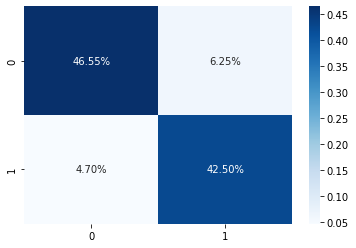

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Blues')

In [ ]:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.890500


In [ ]:
precision = precision_score(flat_true_labels, flat_predictions)
print('Precision: %f' % precision)

Precision: 0.871795


In [ ]:
recall = recall_score(flat_true_labels, flat_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(flat_true_labels, flat_predictions)
print('F1 score: %f' % f1)

Recall: 0.900424
F1 score: 0.885878


In [ ]:


ma=mape(flat_true_labels, flat_predictions)
print('Mean absolute percentage error : ', ma )

Mean absolute percentage error :  0.07825


In [ ]:
type(flat_true_labels)
for index,item in enumerate(flat_true_labels):
  if item==2:
    flat_true_labels[index]=0


In [ ]:
for index,item in enumerate(flat_predictions):
  if item==2:
    flat_predictions[index]=0

In [ ]:
import numpy as np

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

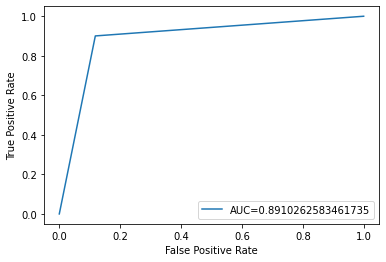

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(flat_true_labels,  flat_predictions)
auc = metrics.roc_auc_score(flat_true_labels,flat_predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
cf_matrix

In [ ]:
sensitivity1 = cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.8816287878787878
Specificity :  0.9004237288135594
